In [15]:
import cv2
import glob
import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

class DistortionCorrector:

    def __init__(self):
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane.
        self.dist = None
        self.mtx = None

    def train(self, file_names="", nx=8, ny=6):
        objp = np.zeros((ny*nx,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
        images = glob.glob(file_names)
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)

                # Draw and display the corners
                # cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
                # write_name = 'corners_found'+str(idx)+'.jpg'
                # cv2.imwrite(write_name, img)
                # cv2.imshow('img', img)
                # cv2.waitKey(500)

        # cv2.destroyAllWindows()

    def cal_undistort(self, img, color_schema=cv2.COLOR_BGR2GRAY, verbose=0):
        gray_img = cv2.cvtColor(img, color_schema)
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, gray_img.shape[::], None, None)
        undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        if verbose != 0:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(img)
            ax1.set_title('Original Image', fontsize=50)
            ax2.imshow(undist)
            ax2.set_title('Undistorted Image', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            plt.show()
        return undist

    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

    
distortion_corrector = DistortionCorrector()
distortion_corrector.train(file_names="./camera_cal/cali*", nx=9, ny=6)


In [20]:
class Utils:
    @staticmethod
    def displaySideBySide(leftImg, leftTitle, rightImg, rightTitle, figsize=(20,10) , leftCmap=None, rightCmap=None):
        fig, axes = plt.subplots(ncols=2, figsize=figsize)
        if leftCmap == None:
            axes[0].imshow(leftImg)
        else:
            axes[0].imshow(leftImg, cmap=leftCmap)
        axes[0].set_title(leftTitle)

        if rightCmap == None:
            axes[1].imshow(rightImg)
        else:
            axes[1].imshow(rightImg, cmap=rightCmap)
        axes[1].set_title(rightTitle)

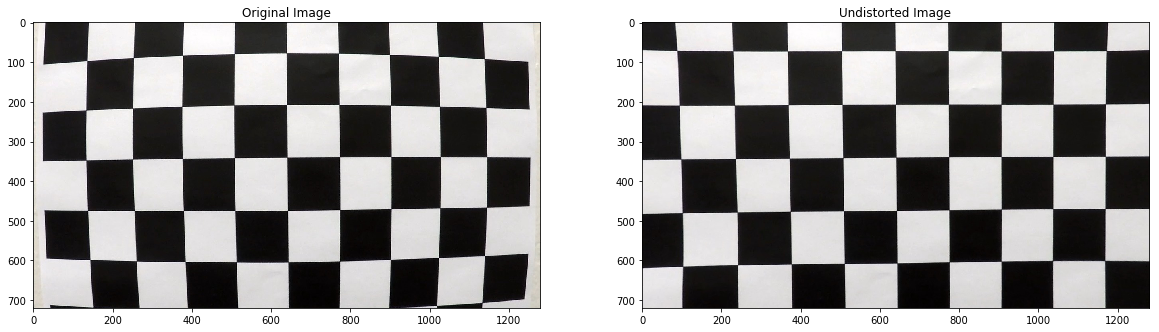

In [21]:

import cv2
import matplotlib
import matplotlib.pyplot as plt

# matplotlib.pyplot.ion()

def calibration_test():
    img = cv2.imread("./camera_cal/calibration1.jpg")
    undist = distortion_corrector.cal_undistort(img)
    Utils.displaySideBySide(cv2.cvtColor(img,cv2.COLOR_BGR2RGB), "Original Image",
        cv2.cvtColor(undist, cv2.COLOR_BGR2RGB), "Undistorted Image")
    
calibration_test()

In [33]:
class PerspectiveTransformer:
    def __init__(self):
        self.M = None
        self.Minv = None
        
    def train(self, img, color_schema=cv2.COLOR_BGR2RGB):
        original = cv2.cvtColor(img, color_schema)
        undist = distortion_corrector.cal_undistort(img)

        xSize, ySize, _ = undist.shape
        copy = undist.copy()

        bottomY = 720
        topY = 455


        left1 = (190, bottomY)
        left1_x, left1_y = left1
        left2 = (585, topY)
        left2_x, left2_y = left2

        right1 = (705, topY)
        right1_x, right1_y = right1

        right2 = (1130, bottomY)
        right2_x, right2_y = right2

        gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
        src = np.float32([ 
            [left2_x, left2_y],
            [right1_x, right1_y],
            [right2_x, right2_y],
            [left1_x, left1_y]
        ])
        nX = gray.shape[1]
        nY = gray.shape[0]
        img_size = (nX, nY)
        offset = 200
        dst = np.float32([
            [offset, 0],
            [img_size[0]-offset, 0],
            [img_size[0]-offset, img_size[1]], 
            [offset, img_size[1]]
        ])
        img_size = (gray.shape[1], gray.shape[0])
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)
        
    def transform(self, img, color_schema=cv2.COLOR_BGR2RGB, verbose=0):
        original = cv2.cvtColor(img, color_schema)
        undist = distortion_corrector.cal_undistort(img)
        img_size = (img.shape[1], img.shape[0])
        warped = cv2.warpPerspective(undist, self.M, img_size)

        if verbose != 0:
            Utils.displaySideBySide(
                original, 'Original',
                warped, 'Perspective transformed')
            
testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.glob('./test_images/st*.jpg')))            
perspective_transformer = PerspectiveTransformer()
perspective_transformer.train(testImages[0][1])


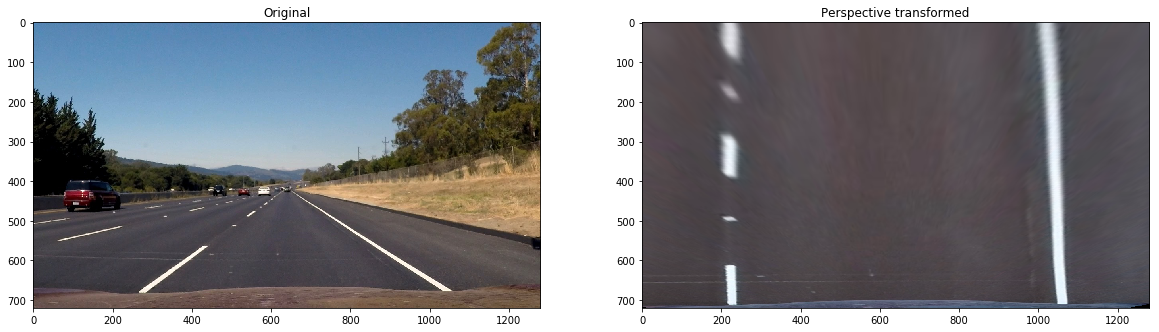

In [34]:
def perspective_transform_test():
    perspective_transformer.transform(testImages[1][1], verbose=1)
    
perspective_transform_test()